Simpsons Face Recognition Program
- Uses tensorflow and Keras 3
- Uses GPU

Before use:
- download the simpsons dataset from Kaggle https://www.kaggle.com/datasets/alexattia/the-simpsons-characters-dataset
- unzip it to a folder named `simpsons_data`
- Ensure the dataset folder path is as such `./simpsons_data/simpsons_dataset/`

In [1]:
# Check if GPU is available

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

2025-01-12 21:51:52.963057: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-12 21:51:53.470460: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736736713.668916    6135 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736736713.730350    6135 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-12 21:51:54.214740: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Num GPUs Available:  1
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4389737024049617018
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6553862144
locality {
  bus_id: 1
  links {
  }
}
incarnation: 18069959171416424319
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9"
xla_global_id: 416903419
]


I0000 00:00:1736736722.553917    6135 gpu_device.cc:2022] Created device /device:GPU:0 with 6250 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [2]:
import os
import caer
import canaro
import numpy as np
import cv2 as cv
import gc

In [3]:
# model expects all image data to be of the same size
# i.e. we will have to resize all images in dataset to a particular size
IMG_SIZE = (80,80)
channels = 1 # i.e. grayscale
character_path = r'./simpsons_data/simpsons_dataset/' # path to dataset

In [4]:
# Creating a character dictionary, sorting it in descending order

# We want to get top 10 characters with most images for that class
# - go through every folder, get name of folder and number of images
#   in the folder, and store this info in a dictionary (hashmap)
character_dict = {}
for character in os.listdir(character_path):
    character_dict[character] = len(os.listdir(os.path.join(character_path, character)))

# sort in decending order
character_dict = caer.sort_dict(character_dict, descending=True)

character_dict

[('homer_simpson', 2246),
 ('ned_flanders', 1454),
 ('moe_szyslak', 1452),
 ('lisa_simpson', 1354),
 ('bart_simpson', 1342),
 ('marge_simpson', 1291),
 ('krusty_the_clown', 1206),
 ('principal_skinner', 1194),
 ('charles_montgomery_burns', 1193),
 ('milhouse_van_houten', 1079),
 ('chief_wiggum', 986),
 ('abraham_grampa_simpson', 913),
 ('sideshow_bob', 877),
 ('apu_nahasapeemapetilon', 623),
 ('kent_brockman', 498),
 ('comic_book_guy', 469),
 ('edna_krabappel', 457),
 ('nelson_muntz', 358),
 ('lenny_leonard', 310),
 ('mayor_quimby', 246),
 ('waylon_smithers', 181),
 ('maggie_simpson', 128),
 ('groundskeeper_willie', 121),
 ('barney_gumble', 106),
 ('selma_bouvier', 103),
 ('carl_carlson', 98),
 ('ralph_wiggum', 89),
 ('patty_bouvier', 72),
 ('martin_prince', 71),
 ('professor_john_frink', 65),
 ('snake_jailbird', 55),
 ('cletus_spuckler', 47),
 ('rainier_wolfcastle', 45),
 ('simpsons_dataset', 42),
 ('agnes_skinner', 42),
 ('sideshow_mel', 40),
 ('otto_mann', 32),
 ('fat_tony', 27),
 (

In [5]:
# Get the names of the top 10 people with most images
characters = []
count = 0
for i in character_dict:
    characters.append(i[0])
    count +=1
    if count >= 10:
        break

characters

['homer_simpson',
 'ned_flanders',
 'moe_szyslak',
 'lisa_simpson',
 'bart_simpson',
 'marge_simpson',
 'krusty_the_clown',
 'principal_skinner',
 'charles_montgomery_burns',
 'milhouse_van_houten']

In [6]:
# Create the training data
# - go through every folder inside character_path, and look at every element
#   inside the characters list
# - it will the images from the top 10 people, to the training set
# - a training set is a list. Each element in the list was another list
#   of image array and its label
train = caer.preprocess_from_dir(character_path, characters, channels=channels, IMG_SIZE=IMG_SIZE, isShuffle=True)

[INFO] Could not find a file to load from. Generating the training data
----------------------------------------------
[INFO] At 1000 files
[INFO] At 2000 files
[INFO] 2246 files found in 0.012404203414916992s
[INFO] At 1000 files
[INFO] 1454 files found in 0.006905555725097656s
[INFO] At 1000 files
[INFO] 1452 files found in 0.007527351379394531s
[INFO] At 1000 files
[INFO] 1354 files found in 0.005001544952392578s
[INFO] At 1000 files
[INFO] 1342 files found in 0.006459474563598633s
[INFO] At 1000 files
[INFO] 1291 files found in 0.0053484439849853516s
[INFO] At 1000 files
[INFO] 1206 files found in 0.003937244415283203s
[INFO] At 1000 files
[INFO] 1194 files found in 0.004413604736328125s
[INFO] At 1000 files
[INFO] 1193 files found in 0.004606008529663086s
[INFO] At 1000 files
[INFO] 1079 files found in 0.0038411617279052734s
----------------------------------------------
[INFO] 13811 files preprocessed! Took 0m 39s


In [7]:
len(train) # number of images (training samples) in the training set

13811

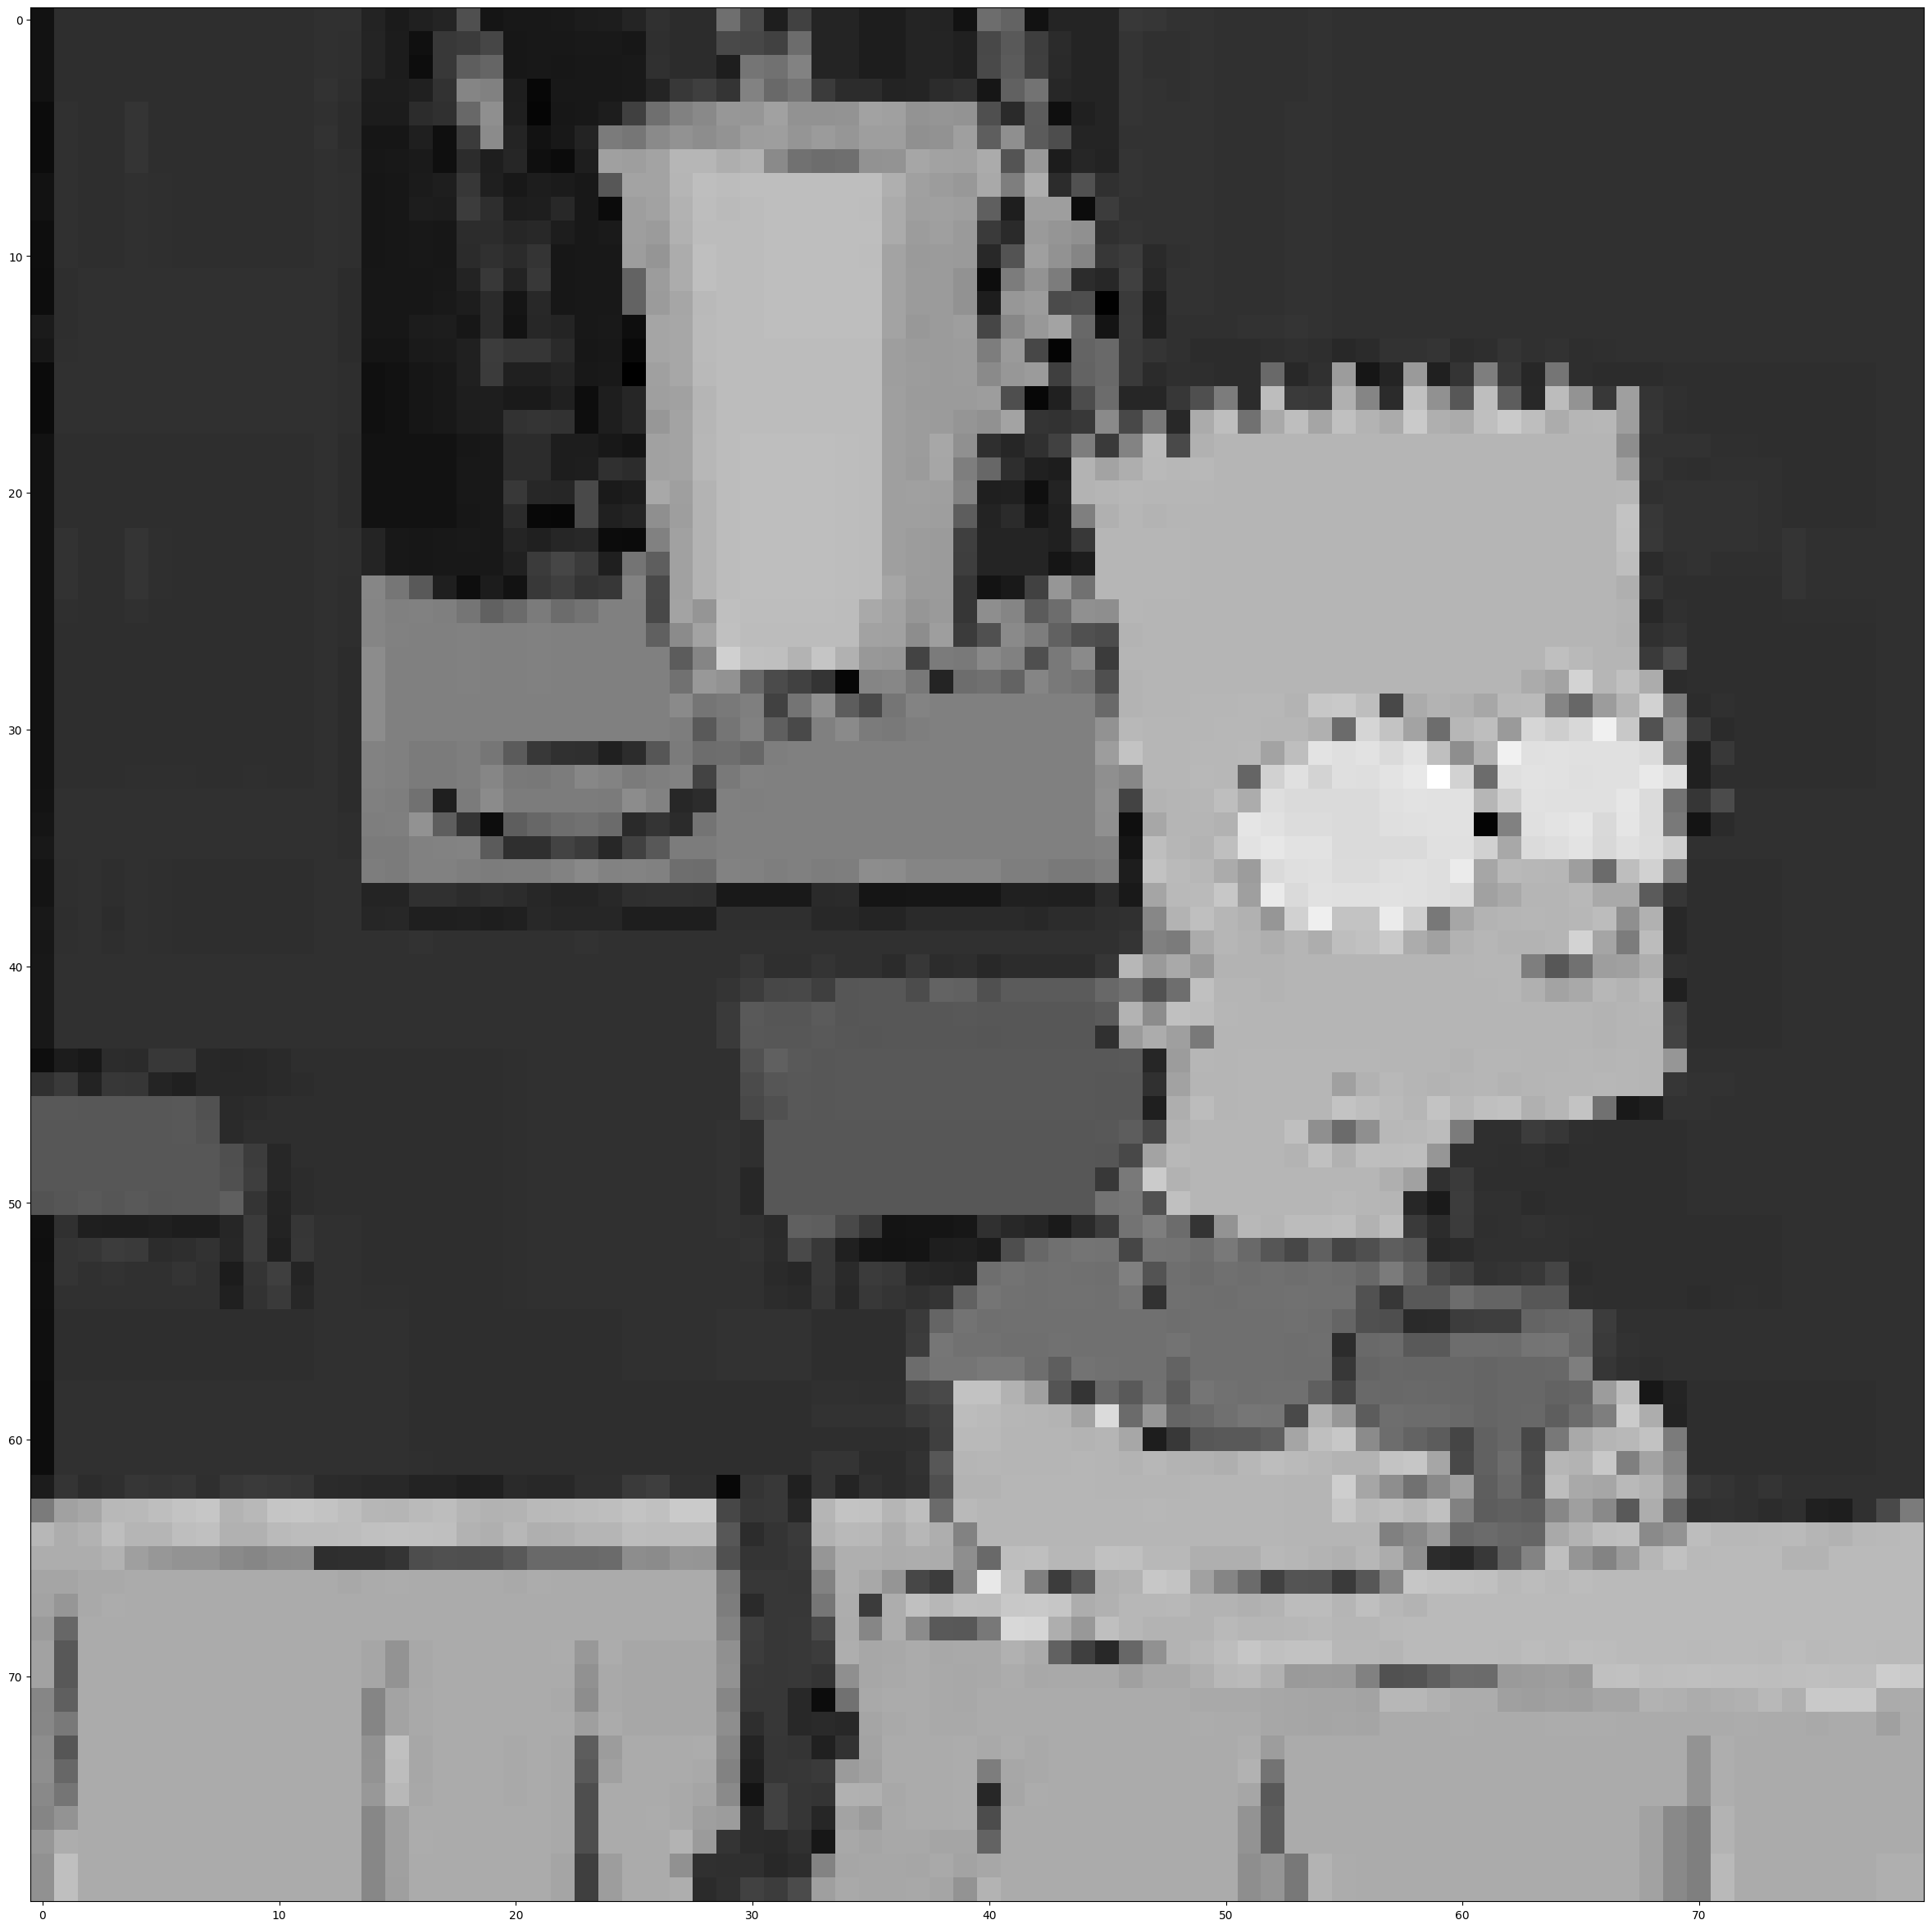

In [8]:
# Visualizing the data (OpenCV doesn't display well in Jupyter notebooks)

# diplay an image in the training set
import matplotlib.pyplot as plt
plt.figure(figsize=(30,30))
plt.imshow(train[0][0], cmap='gray')
plt.show()

In [9]:
# separate training set into labels and features (separate lists)
# and also reshape the featureSet into a 4D tensor, so that it can be 
# fed into the model without any restrictions
featureSet, labels = caer.sep_train(train, IMG_SIZE=IMG_SIZE)

In [10]:
# from tensorflow.python.keras.utils.np_utils import to_categorical # NOTE: Needed utils.np_utils
from tensorflow.keras.utils import to_categorical

# Normalize the featureSet ==> make data within range of (0,1)
featureSet = caer.normalize(featureSet)

# convert numerical labels from class vector (integers) to binary class matrix.
labels = to_categorical(labels, len(characters))

In [11]:
# splitting featureset and labels into training set and validation set
# so in this case, 20% goes to validation, 80% goes to training
x_train, x_val, y_train, y_val = caer.train_val_split(featureSet, labels, val_ratio=.2)


# Extra stuff:
# import sklearn.model_selection as skm
# split_data = skm.train_test_split(featureSet, labels, test_size=.2)
# x_train, x_val, y_train, y_val = (np.array(item) for item in split_data)

In [12]:
# can now delete unneeded variables
del train 
del featureSet
del labels
gc.collect()

0

In [13]:
# Useful variables when training
BATCH_SIZE = 32
EPOCHS = 10

In [14]:
# Image data generator
# - image generator that makes new images from existing ones to improve our network
# - introduces randomness in network ==> better accuracy
datagen = canaro.generators.imageDataGenerator()
train_gen = datagen.flow(x_train, y_train, batch_size=BATCH_SIZE)


In [15]:
# Create our model (returns a compiled model)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D

output_dim=10

w, h = IMG_SIZE[:2]

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(w, h,channels)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(256, (3, 3), padding='same', activation='relu')) 
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))

# Output Layer
model.add(Dense(output_dim, activation='softmax'))


/home/ashish/miniconda3/envs/cv-gpu/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1736736764.567192    6135 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6250 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [16]:
# print summary of the model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 80, 80, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 78, 78, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 39, 39, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 39, 39, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 39, 39, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 37, 37, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 18, 18, 256)    │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    16,778,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │        10,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,591,274 (67.11 MB)

 Trainable params: 17,591,274 (67.11 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# compile the model
model.compile(loss='binary_crossentropy')

In [18]:
# Training the model
# - create a callbacks list
# - contains a learning rate scheduler - schedules learning rate at certain intervals to allow the network to train better

from tensorflow.keras.callbacks import LearningRateScheduler
callbacks_list = [LearningRateScheduler(canaro.lr_schedule)]

training = model.fit(train_gen,
                    steps_per_epoch=len(x_train)//BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(x_val,y_val),
                    validation_steps=len(y_val)//BATCH_SIZE,
                    callbacks = callbacks_list)

/home/ashish/miniconda3/envs/cv-gpu/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1736736770.027960    6372 service.cc:148] XLA service 0x7f8af4001bf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1736736770.030293    6372 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-01-12 21:52:50.170446: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1736736770.755715    6372 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-01-12 21:52:51.367329: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version 12.5.82. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
2025-01

  3/345 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - loss: 9.8346   

I0000 00:00:1736736784.240890    6372 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


345/345 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 1.2794

2025-01-12 21:53:32.259357: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_99', 132 bytes spill stores, 132 bytes spill loads

2025-01-12 21:53:32.476333: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_99', 496 bytes spill stores, 392 bytes spill loads

2025-01-12 21:53:36.224060: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_99', 132 bytes spill stores, 132 bytes spill loads

2025-01-12 21:53:36.263858: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_99', 280 bytes spill stores, 280 bytes spill loads



345/345 ━━━━━━━━━━━━━━━━━━━━ 50s 97ms/step - loss: 1.2772 - val_loss: 0.3242 - learning_rate: 0.0100
Epoch 2/10
  1/345 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.3231

/home/ashish/miniconda3/envs/cv-gpu/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


345/345 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3231 - val_loss: 0.3248 - learning_rate: 0.0100
Epoch 3/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - loss: 0.3256 - val_loss: 0.3235 - learning_rate: 0.0100
Epoch 4/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3223 - val_loss: 0.3237 - learning_rate: 0.0100
Epoch 5/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - loss: 0.3234 - val_loss: 0.3231 - learning_rate: 0.0100
Epoch 6/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3367 - val_loss: 0.3229 - learning_rate: 0.0100
Epoch 7/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - loss: 0.3236 - val_loss: 0.3232 - learning_rate: 0.0100
Epoch 8/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3224 - val_loss: 0.3233 - learning_rate: 0.0100
Epoch 9/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - loss: 0.3235 - val_loss: 0.3232 - learning_rate: 0.0100
Epoch 10/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3264 - val_loss: 0.3231 - learning_rate: 0.0100


TESTING

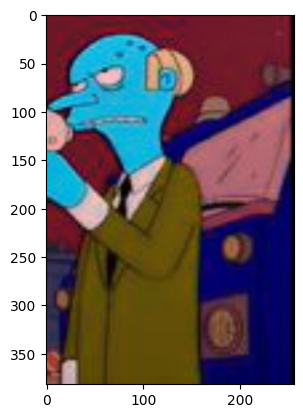

In [19]:
# read in an image to use for testing
test_path = r'./simpsons_data/simpsons_dataset/charles_montgomery_burns/pic_0011.jpg'
img = cv.imread(test_path)
plt.imshow(img)
plt.show()

In [20]:
# make test image into same size and shape as the images we used in our model
def prepare(image):
    image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    image = cv.resize(image, IMG_SIZE)
    image = caer.reshape(image, IMG_SIZE, 1)
    return image

In [21]:
# make predictions list (it is a list of 0s and 1s showing which of the 10 people it predicts it is)
predictions = model.predict(prepare(img))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [22]:
# Getting class with the highest probability
print(characters[np.argmax(predictions[0])])

lisa_simpson
